In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# The Data

Split the dataset in to train and test. We are using training data only for EDA.

In [2]:
df = pd.read_csv('train.tsv', sep = '\t')

In [3]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [4]:
train.shape, test.shape

((1185916, 8), (296619, 8))

# EDA

In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1185916 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1185916 non-null  int64  
 1   name               1185916 non-null  object 
 2   item_condition_id  1185916 non-null  int64  
 3   category_name      1180854 non-null  object 
 4   brand_name         679628 non-null   object 
 5   price              1185916 non-null  float64
 6   shipping           1185916 non-null  int64  
 7   item_description   1185913 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 81.4+ MB


## Price

In [7]:
train.price.describe()

count    1.185916e+06
mean     2.672938e+01
std      3.851281e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

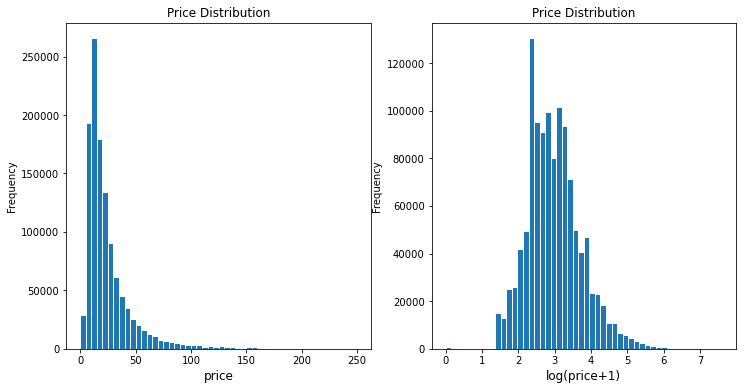

In [8]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins = 50, figsize = (12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize = 12)
plt.title('Price Distribution', fontsize = 12)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins = 50, figsize = (12, 6), edgecolor = 'white')
plt.xlabel('log(price+1)', fontsize = 12)
plt.title('Price Distribution', fontsize = 12)

The price of items are left skewed, vast majority of items priced at 10-20. However, the most expensive item priced at 2009. So we make log-transformation on the price.

## Shipping

In [9]:
train['shipping'].value_counts() / len(train)

0    0.552684
1    0.447316
Name: shipping, dtype: float64

Over 55% of items shipping fee were paid by the buyers. How shipping related to price?

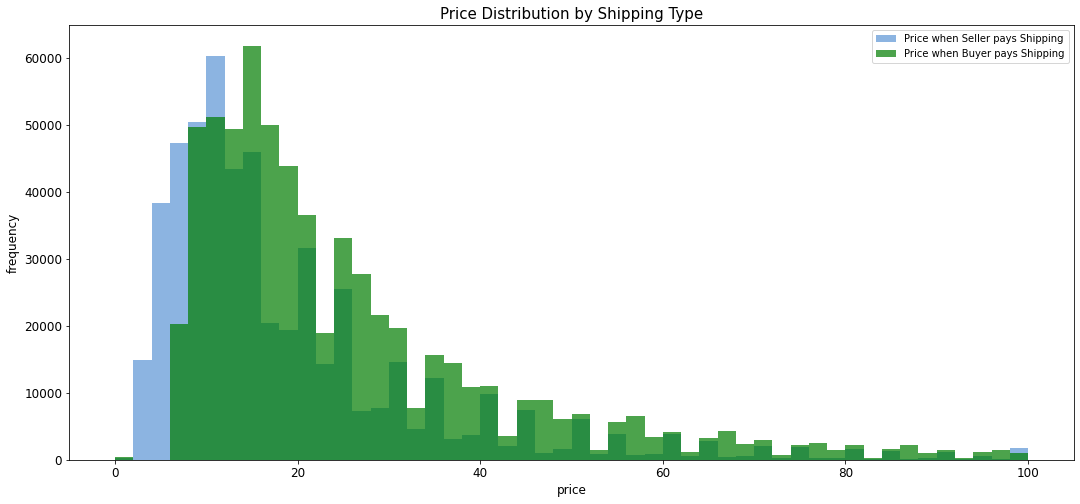

In [10]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize = (18, 8))
ax.hist(shipping_fee_by_seller, color = '#8CB4E1', alpha = 1.0, bins = 50, range = [0, 100],
       label = 'Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color = '#007D00', alpha = 0.7, bins = 50, range = [0, 100],
       label = 'Price when Buyer pays Shipping')
plt.xlabel('price', fontsize = 12)
plt.ylabel('frequency', fontsize = 12)
plt.title('Price Distribution by Shipping Type', fontsize = 15)
plt.tick_params(labelsize = 12)
plt.legend()
plt.show()

In [11]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.56 if seller pays shipping
The average price is 30.1 if buyer pays shipping


We compare again after log-transformation on the price.

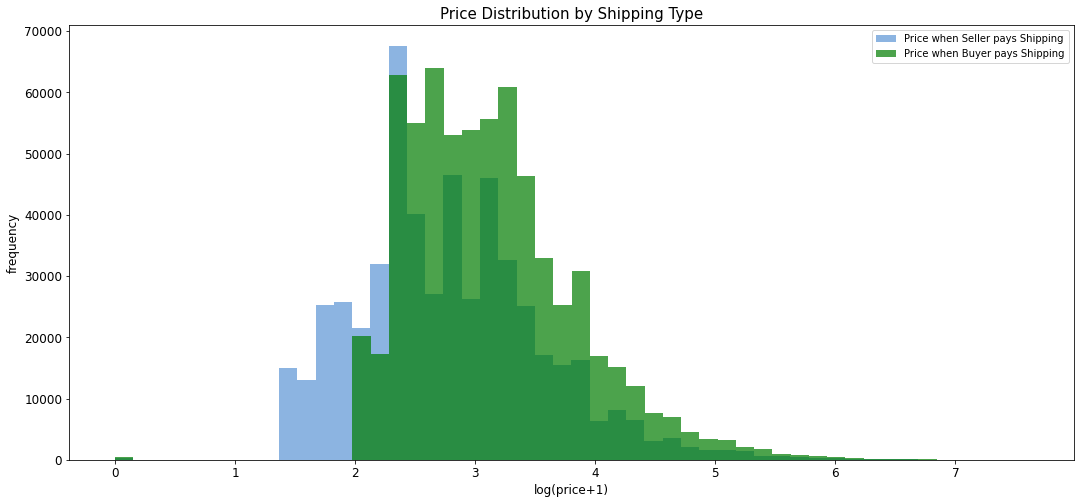

In [12]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.hist(np.log(shipping_fee_by_seller+1), color = '#8CB4E1', alpha = 1.0, bins = 50,
       label = 'Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color = '#007D00', alpha = 0.7, bins = 50,
       label = 'Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize = 12)
plt.ylabel('frequency', fontsize = 12)
plt.title('Price Distribution by Shipping Type', fontsize = 15)
plt.tick_params(labelsize = 12)
plt.legend()
plt.show()

It is obvious that the average price is higher when buyer pays shipping.

## Category Names

### Category names

In [13]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1266 unique values in category name column


Top 10 most common category names

In [14]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 48097
Women/Tops & Blouses/T-Shirts                                  37086
Beauty/Makeup/Face                                             27442
Beauty/Makeup/Lips                                             23888
Electronics/Video Games & Consoles/Games                       21314
Beauty/Makeup/Eyes                                             20155
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    19672
Women/Underwear/Bras                                           17010
Women/Tops & Blouses/Blouse                                    16210
Women/Tops & Blouses/Tank, Cami                                16162
Name: category_name, dtype: int64

### Item condition vs. Price

<AxesSubplot:xlabel='item_condition_id', ylabel='price'>

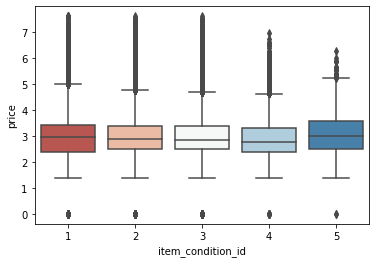

In [15]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu', 5))

There seems to be various on the average price between each item condition id.

Therefore, we are going to use all the features to build our model.

# LightGBM

## Settings

In [16]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

There are missing values in the columns.

In [17]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 5062 items that do not have a category name.


In [18]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 506288 items that do not have a brand name.


In [19]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 3 items that do not have a description.


In [20]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value = 'missing', inplace = True) 
    dataset['brand_name'].fillna(value = 'missing', inplace = True) 
    dataset['item_description'].replace('No description yet,''missing', inplace = True) 
    dataset['item_description'].fillna(value = 'missing', inplace = True)

In [21]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [22]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [23]:
df = pd.read_csv('train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis = 1)
y_test = np.log1p(test["price"])

Drop rows where price = 0

In [24]:
train = train[train.price != 0].reset_index(drop = True)

In [25]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [26]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [27]:
merge.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
1,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
2,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
3,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity
4,5,Bundled items requested for Ruie,3,Women/Other/Other,missing,59.0,0,"Banana republic bottoms, Candies skirt with ma..."


Count vectorize name and category name columns.

In [28]:
cv = CountVectorizer(min_df = NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [29]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

TFIDF Vectorize item_description column.

In [30]:
tv = TfidfVectorizer(max_features = MAX_FEATURES_ITEM_DESCRIPTION, ngram_range = (1, 3), stop_words = 'english')
X_description = tv.fit_transform(merge['item_description'])

Label binarize brand_name column.

In [31]:
lb = LabelBinarizer(sparse_output = True)
X_brand = lb.fit_transform(merge['brand_name'])

Create dummy variables for item_condition_id and shipping columns.

In [32]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse = True).values)

Create sparse merge.

In [33]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [34]:
sparse_merge.shape

(1481830, 72754)

Remove features with document frequency <=1.

In [35]:
mask = np.array(np.clip(sparse_merge.getnnz(axis = 0) - 1, 0, 1), dtype = bool)
sparse_merge = sparse_merge[:, mask]

In [36]:
sparse_merge.shape

(1481830, 72288)

Separate train and test data from sparse merge.

In [37]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [38]:
train_X = lgb.Dataset(X, label = y)

In [39]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

### Training
Training a model requires a parameter list and data set. And training will take a while.

In [40]:
gbm = lgb.train(params, train_set = train_X, num_boost_round = 3200, verbose_eval = 100)

C:\Users\91773\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


KeyboardInterrupt: 

### Prediction

In [ ]:
y_pred = gbm.predict(X_test, num_iteration = gbm.best_iteration)

In [ ]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)